In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../')

# Graph imports
from src.graph import GraphModel 
import src.estimator as estimator
import src.utils as utils

# usual imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx

from IPython.display import display
from pyvis.network import Network

import pickle
import os

np.random.seed(42)

In [2]:
path = '../data/connectomes/'
connectomes = os.listdir(path)
connectomes

['rattus.norvegicus_brain_1.graphml',
 'rhesus_brain_1.graphml',
 'mouse_brain_1.graphml']

In [3]:
nx.read_graphml

<function networkx.readwrite.graphml.read_graphml(path, node_type=<class 'str'>, edge_key_type=<class 'int'>, force_multigraph=False, *, backend=None, **backend_kwargs)>

# Mouse Brain

In [4]:
extension = 'graphml'
name = 'mouse_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/mouse_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_75315/4171854464.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [6]:
est = estimator.LogitRegEstimator(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.122     
Date:               2024-04-18 12:09 AIC:              23874.4390
No. Observations:   22731            BIC:              23898.5335
Df Model:           2                Log-Likelihood:   -11934.   
Df Residuals:       22728            LL-Null:          -13594.   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     31.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -6.7872     0.1466   -46.3040   0.0000   -7.0745   -6.4999
x1        0.0261     0.0007    39.0098   0.0000    0.0248    0.0274
x2        0.0255     0.0006    40.1449   0.0000    0.0242    0.0267



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [7]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [8]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.051643192488262914
KS Statistic: 0.046948356807511735
KS Statistic: 0.07042253521126761
KS Statistic: 0.04225352112676056
Degree Distribution Stable: True
Graph Converged: True






In [9]:
g_est = graphs[-1]
s_est = spec[-1]

## Visualizations

In [10]:
ut = utils.GraphUtils()

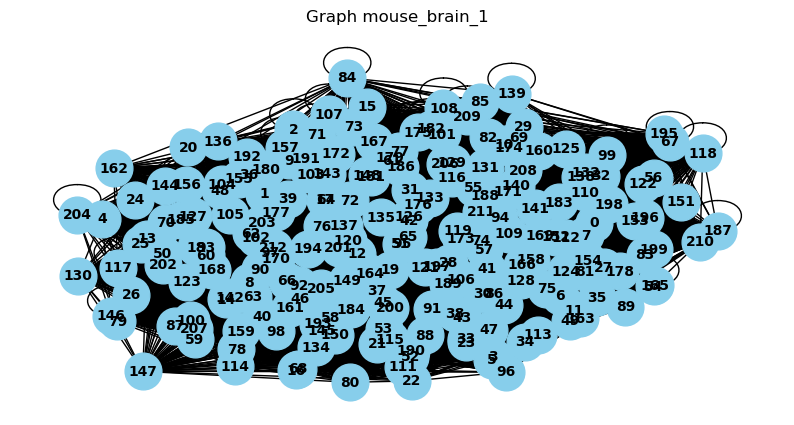

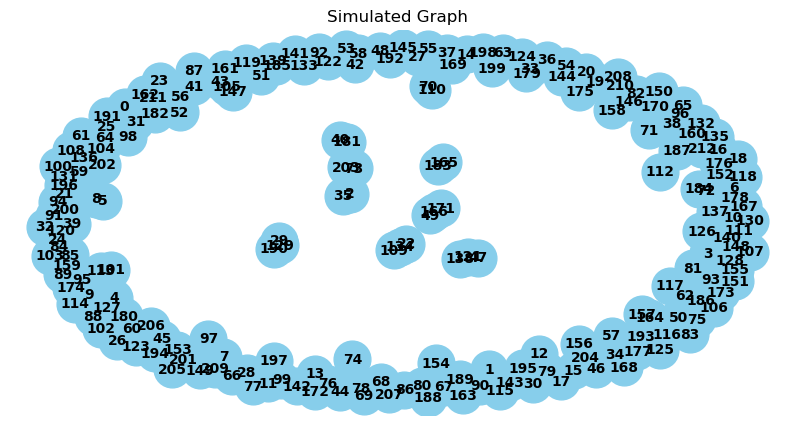

In [11]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


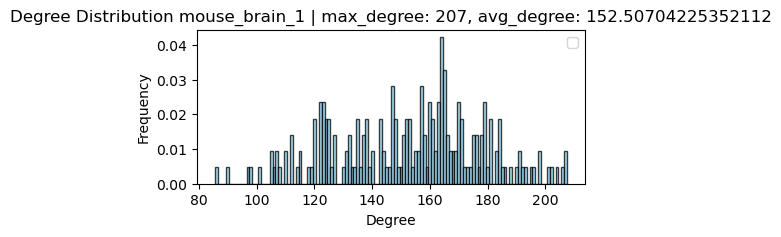

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


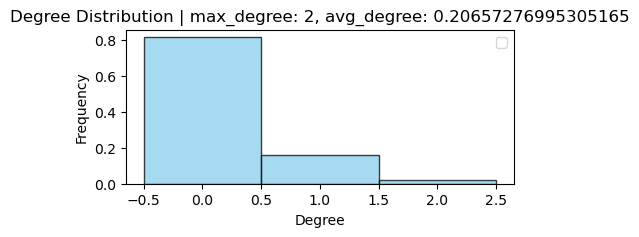

In [12]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

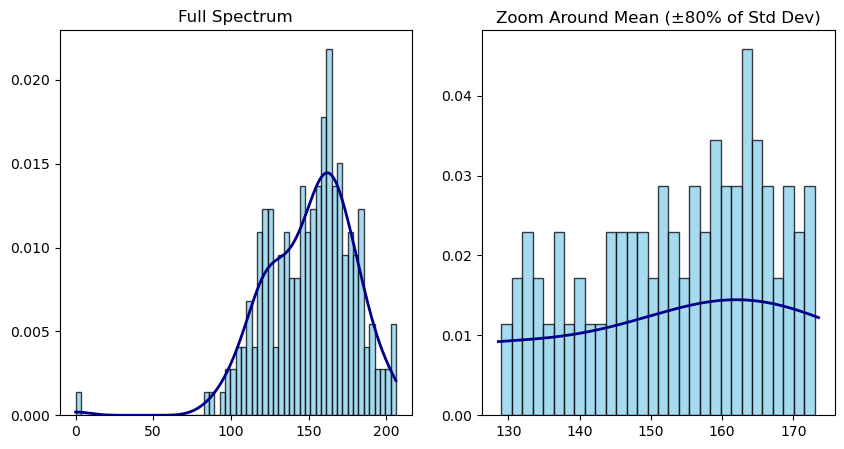

ValueError: `dataset` input should have multiple elements.

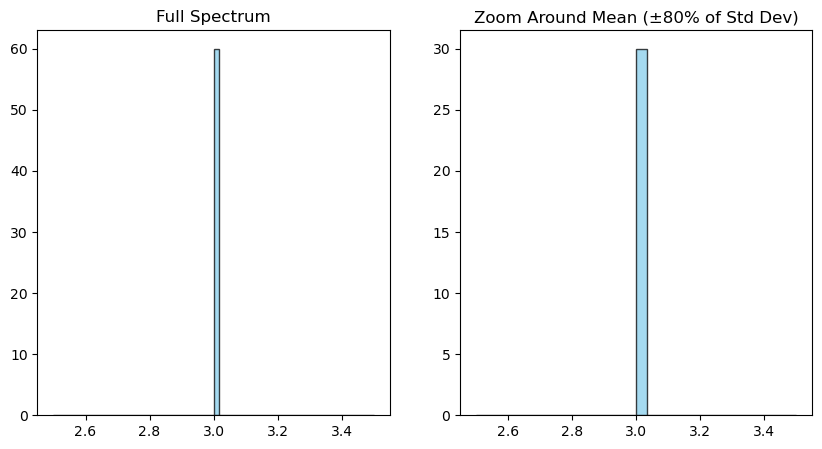

In [13]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model Selection

In [14]:
import src.model_selection as ms 

real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: mouse_brain_1
The best model is: WS
Model scores:
ER: 5.30865603713574
WS: 4.660588662210864
BA: 7.134053799740398
LG: 12.191155546084822


# Rhesus Brain

In [15]:
extension = 'graphml'
name = 'rhesus_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/rhesus_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_75315/3919072262.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [16]:
est = estimator.LogitRegEstimator(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: y                Pseudo R-squared: 0.169     
Date:               2024-04-18 12:09 AIC:              16250.0865
No. Observations:   29161            BIC:              16274.9283
Df Model:           2                Log-Likelihood:   -8122.0   
Df Residuals:       29158            LL-Null:          -9779.2   
Converged:          1.0000           LLR p-value:      0.0000    
No. Iterations:     28.0000          Scale:            1.0000    
-------------------------------------------------------------------
          Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const    -4.6418     0.0581   -79.9039   0.0000   -4.7556   -4.5279
x1        0.0443     0.0010    45.0406   0.0000    0.0424    0.0463
x2        0.0364     0.0011    34.0141   0.0000    0.0343    0.0385



/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/discrete/discrete_model.py:2443: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:71: ConvergenceWarning: QC check did not pass for 2 out of 3 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
  warnings.warn(message, ConvergenceWarning)
/Users/maruanottoni/miniforge3/envs/gt/lib/python3.12/site-packages/statsmodels/base/l1_solvers_common.py:144: ConvergenceWarning: Could not trim params automatically due to failed QC check. Trimming using trim_mode == 'size' will still work.
  warnings.warn(msg, ConvergenceWarning)


In [17]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [18]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.07024793388429752
KS Statistic: 0.0371900826446281
KS Statistic: 0.1115702479338843
KS Statistic: 0.0371900826446281
Degree Distribution Stable: True
Graph Converged: True






In [24]:
g_est = graphs[-1]
s_est = spec

## Visualizations

In [25]:
ut = utils.GraphUtils()

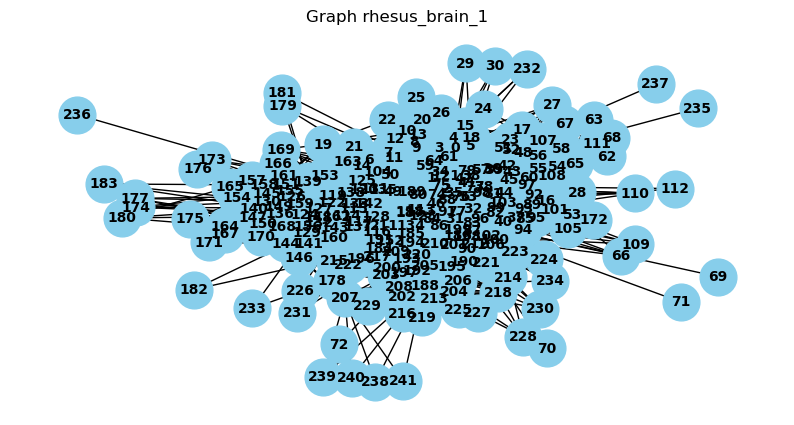

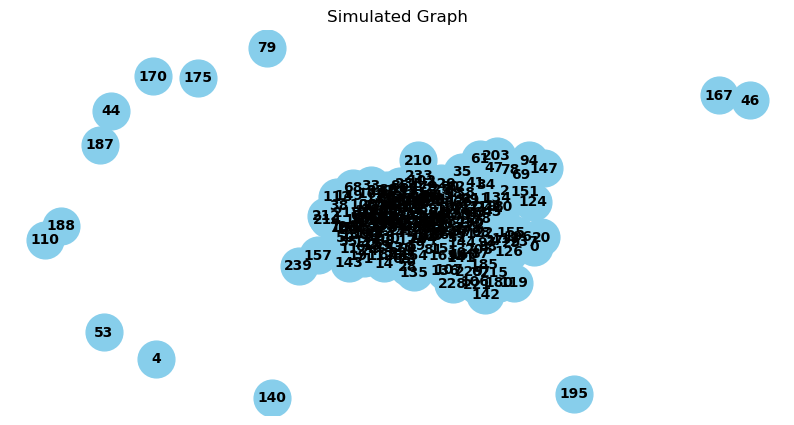

In [26]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


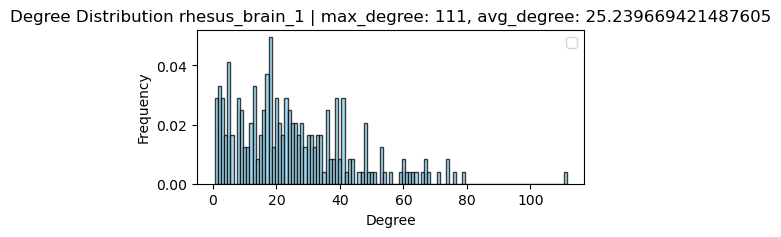

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


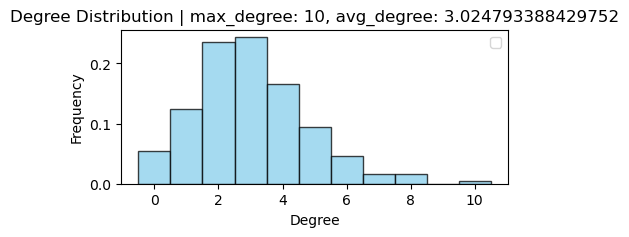

In [27]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

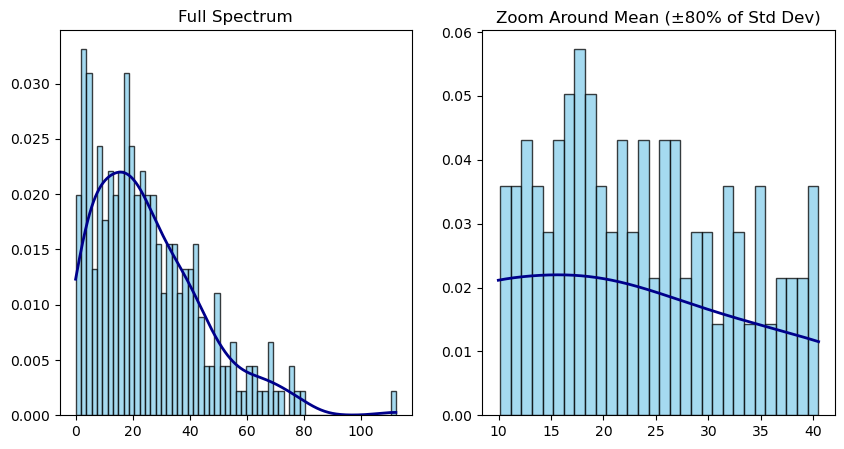

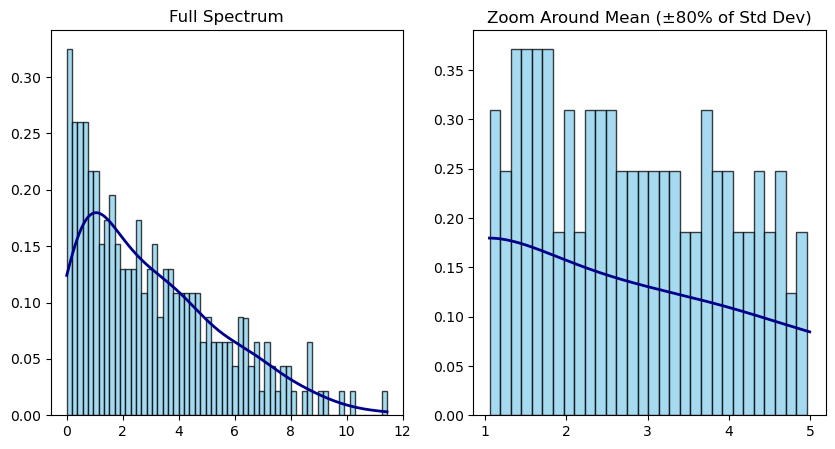

In [28]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model selection

In [36]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: rhesus_brain_1
The best model is: ER
Model scores:
ER: 10.745605312228461
WS: 11.131962608264145
BA: 12.87066152616047
LG: 14.362336092563943


# Rattus norvegicus

In [37]:
extension = 'graphml'
name = 'rattus.norvegicus_brain_1'
file_path = f'{path}{name}.{extension}'
print(file_path)
connectome = nx.read_graphml(file_path)
g = nx.adjacency_matrix(connectome).A
g.shape[0]
s = GraphModel.calculate_spectrum(g)

../data/connectomes/rattus.norvegicus_brain_1.graphml


/var/folders/ns/zy_pbb_s3591fwh2_q7z6g0h0000gn/T/ipykernel_34087/2364455897.py:6: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.14.0. Use `.toarray()` instead.
  g = nx.adjacency_matrix(connectome).A


In [38]:
est = estimator.LogitRegEstimator2(g)
params, pvalues = est.estimate_parameters()
sigma, alpha, beta = params

                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:               126253
Model:                          Logit   Df Residuals:                   126250
Method:                           MLE   Df Model:                            2
Date:                Mon, 15 Apr 2024   Pseudo R-squ.:                  0.7385
Time:                        14:39:21   Log-Likelihood:                -15684.
converged:                       True   LL-Null:                       -59974.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.8765      0.031   -186.786      0.000      -5.938      -5.815
x1             0.0160   9.82e-05    162.780      0.000       0.016       0.016
x2             0.0177      0.000    128.636      0.0

In [39]:
n = g.shape[0]
p = 0

alpha = alpha   #  negative 0.003
beta  = beta    #  negative the higher the more concentrated will be the edges into a single vertex 0.003
sigma = sigma    # intercept the higher the harder for creating edges 6

threshold   = 0.5
n_iteration = 50
warm_up     = 30

params_dict = {
    "n": n,
    "p": p,
    "alpha": alpha,
    "beta": beta,
    "sigma": sigma,
    "threshold": threshold,
    "n_iteration": n_iteration,
    "warm_up": warm_up
}

In [40]:
graph = GraphModel(**params_dict)
graphs, spec = graph.populate_edges( warm_up = warm_up, max_iterations = n_iteration, degree_dist_threshold=0.5, stability_window=5)

iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
KS Statistic: 0.02982107355864811
KS Statistic: 0.03180914512922465
KS Statistic: 0.055666003976143144
KS Statistic: 0.03180914512922465
Degree Distribution Stable: True
Graph Converged: True






In [41]:
g_est = graphs[-1]
s_est = spec[-1]

## Visualizations

In [42]:
ut = utils.GraphUtils()

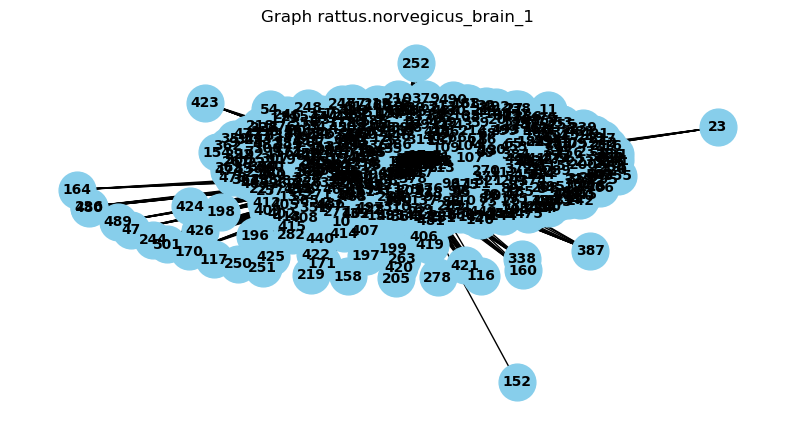

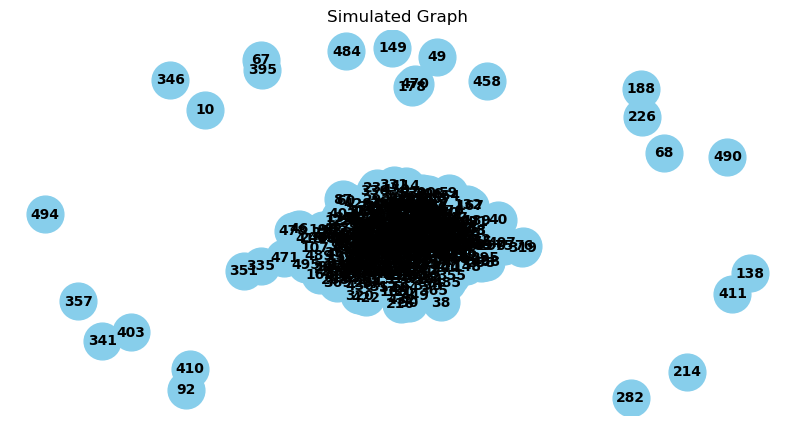

In [43]:
fig = ut.plot_graph_from_adjacency(g, pos=None, title='Graph ' + name, size=(10,5))
fig_est = ut.plot_graph_from_adjacency(g_est, pos=None, title = 'Simulated Graph', size=(10,5))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


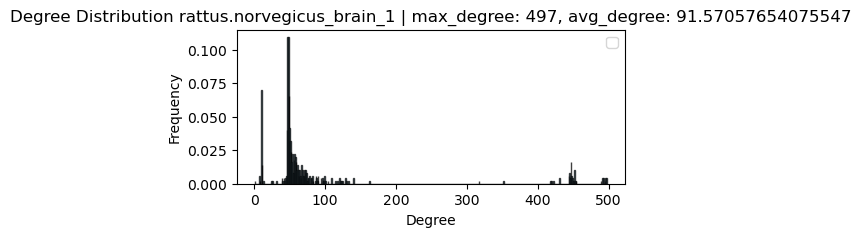

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


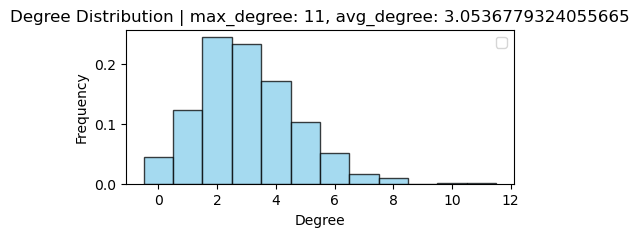

In [44]:
fig = ut.plot_degree_distribution(g, title='Degree Distribution '+name, size=(5,2))
fig_est = ut.plot_degree_distribution(g_est, title='Degree Distribution', size=(5,2))

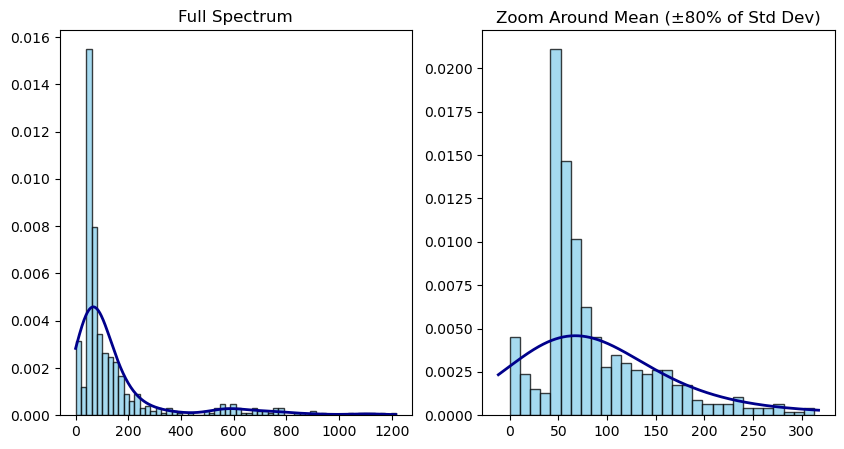

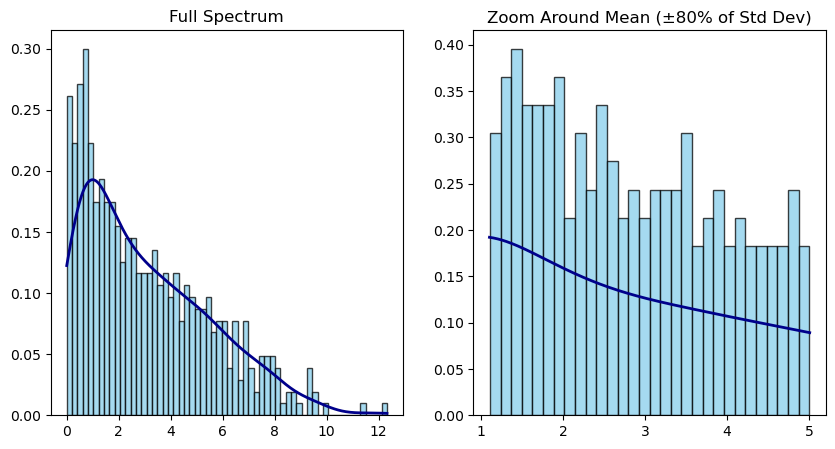

In [45]:
graph_model = GraphModel
s = graph_model.calculate_spectrum(g)
fig = ut.plot_spectrum_and_zoom(s, zoom_scale=0.8, size=(10,5))
fig_est = ut.plot_spectrum_and_zoom(s_est, zoom_scale=0.8, size=(10,5))

## Model selection

In [56]:
import src.model_selection as ms 
real_graph = nx.from_numpy_array(g)
logit_graph = nx.from_numpy_array(g_est)

selector = ms.ModelSelectorSpectrum(real_graph = real_graph, logit_graph = logit_graph)

# Fit models and find the best model
best_model, model_scores = selector.fit()
print(f'for: {name}')
print(f"The best model is: {best_model}")
print("Model scores:")
for model, score in model_scores.items():
    print(f"{model}: {score}")


for: rattus.norvegicus_brain_1
The best model is: LG
Model scores:
ER: 0.7658749412180563
WS: -0.6257496359499564
BA: 0.6305935610164002
LG: -0.6735990310970768
